# **AI Assignment 3: Game Playing**

**CS24M101 - A Sai Jagadeesh**


**CS24M111 - G Kavyasri**

**Algorithms**

1. Minimax
2. αβ-pruning

**Environments**
1. Slime Volleyball
2. Chess

Execute both algorithms in the same environment(We used Chess Env) and submit videos of the entire games too.

In [ ]:
!apt-get update -qq && \
apt-get install -y libcairo2-dev libjpeg-dev libpng-dev pkg-config


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libcairo2-dev is already the newest version (1.16.0-5ubuntu2).
libjpeg-dev is already the newest version (8c-2ubuntu10).
libpng-dev is already the newest version (1.6.37-3build5).
pkg-config is already the newest version (0.29.2-1ubuntu3).
The following packages were automatically installed and are no longer required:
  libbz2-dev libpkgconf3 libreadline-dev
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In [ ]:
#Installing Libraries
!pip install --quiet \
    cairosvg \
    python-chess \
    gym-chess \
    imageio \
    pillow \
    matplotlib


In [ ]:
#Cloning the Chess Environment

!git clone https://github.com/iamlucaswolf/gym-chess.git
%cd gym-chess
#editable mode
!pip install -e .
%cd ..


fatal: destination path 'gym-chess' already exists and is not an empty directory.
/content/gym-chess
Obtaining file:///content/gym-chess
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
ERROR: Project file:///content/gym-chess has a 'pyproject.toml' and its build backend is missing the 'build_editable' hook. Since it does not have a 'setup.py' nor a 'setup.cfg', it cannot be installed in editable mode. Consider using a build backend that supports PEP 660.
/content


**Minimax**

In [ ]:
%%writefile minimax_chess.py
# ─────────────────────────────────────────────────────────────────────────────
# minimax_chess.py
# ─────────────────────────────────────────────────────────────────────────────

#!/usr/bin/env python
import gym, gym_chess, chess, chess.svg, math, random, io, time, numpy as np
import cairosvg, imageio
from PIL import Image

#render board to numpy array via SVG → PNG
def display_board(board, last_move=None, size=352):
    """it returns current board as an RGB array, highlighting the last move."""
    svg = chess.svg.board(board, lastmove=last_move, size=size)
    png = cairosvg.svg2png(bytestring=svg.encode('utf-8'))
    return np.array(Image.open(io.BytesIO(png)))

#Evaluation Function
def evaluate_board(board, agent_color=chess.WHITE):
    """
    Simple material-count used:
      +1 pawn, +3 knight/bishop, +5 rook, +9 queen.
    Checkmate gives ±9999, draws zero.
    """
    if board.is_checkmate():
        # if it's agent's turn and checkmated → agent lost
        return -9999 if board.turn == agent_color else 9999
    if board.is_stalemate() or board.is_insufficient_material():
        return 0

    values = {
        chess.PAWN:   1,
        chess.KNIGHT: 3,
        chess.BISHOP: 3,
        chess.ROOK:   5,
        chess.QUEEN:  9,
        chess.KING:   0,
    }
    total = 0
    for p in board.piece_map().values():
        v = values[p.piece_type]
        total += v if p.color == agent_color else -v
    return total

# Minimax with Node Counting
node_count = 0

def minimax(board, depth, maximizing, agent_color):
    global node_count
    node_count += 1
    if depth == 0 or board.is_game_over():
        return evaluate_board(board, agent_color)

    if maximizing:
        best = -math.inf
        for mv in board.legal_moves:
            board.push(mv)
            val = minimax(board, depth - 1, False, agent_color)
            board.pop()
            best = max(best, val)
        return best
    else:
        worst = math.inf
        for mv in board.legal_moves:
            board.push(mv)
            val = minimax(board, depth - 1, True, agent_color)
            board.pop()
            worst = min(worst, val)
        return worst

def choose_best_move(board, depth, agent_color):
    """Scan all legal moves, run minimax, pick the highest-scoring one."""
    best_val, best_mv = -math.inf, None
    for mv in board.legal_moves:
        board.push(mv)
        val = minimax(board, depth - 1, False, agent_color)
        board.pop()
        if val > best_val:
            best_val, best_mv = val, mv
    return best_mv

#Run One Game & Record Video
def run_minimax_game(depth=3, fps=2):
    env = gym.make("Chess-v0")
    board = env.reset()
    frames = []
    log = []
    global node_count
    node_count = 0

    while not board.is_game_over():
        mover = "WHITE" if board.turn == chess.WHITE else "BLACK"
        if board.turn == chess.WHITE:
            mv = choose_best_move(board, depth, chess.WHITE)
        else:
            mv = random.choice(list(board.legal_moves))
        log.append(f"Step {len(log)+1}: {mover} plays {mv.uci()}")
        board, _, _, _ = env.step(mv)
        frames.append(display_board(board, mv))

    # final result
    if board.is_checkmate():
        winner = "WHITE" if board.turn == chess.BLACK else "BLACK"
        log.append(f"Game over: {winner} wins by checkmate")
    else:
        log.append("Game over: Draw")

    imageio.mimsave("minimax_game.mp4", frames, fps=fps,macro_block_size=1)
    return log, node_count

# Main Function
if __name__ == "__main__":
    print("=== Minimax Agent vs Random Opponent ===")
    moves, total_nodes = run_minimax_game(depth=3)
    for line in moves:
        print(line)
    print(f"\nTotal nodes evaluated: {total_nodes}")


Overwriting minimax_chess.py


In [ ]:
!python3 minimax_chess.py
from IPython.display import Video
Video("minimax_game.mp4", embed=True)

=== Minimax Agent vs Random Opponent ===
Step 1: WHITE plays g1h3
Step 2: BLACK plays d7d5
Step 3: WHITE plays h3g5
Step 4: BLACK plays c7c6
Step 5: WHITE plays h1g1
Step 6: BLACK plays e7e5
Step 7: WHITE plays h2h4
Step 8: BLACK plays f7f6
Step 9: WHITE plays g5h3
Step 10: BLACK plays h7h5
Step 11: WHITE plays g1h1
Step 12: BLACK plays d8e7
Step 13: WHITE plays h3g1
Step 14: BLACK plays e7f7
Step 15: WHITE plays e2e3
Step 16: BLACK plays g7g6
Step 17: WHITE plays h1h2
Step 18: BLACK plays d5d4
Step 19: WHITE plays e3d4
Step 20: BLACK plays f7e7
Step 21: WHITE plays d1e2
Step 22: BLACK plays c6c5
Step 23: WHITE plays e2b5
Step 24: BLACK plays b8d7
Step 25: WHITE plays d4c5
Step 26: BLACK plays h8h6
Step 27: WHITE plays h2h3
Step 28: BLACK plays e7h7
Step 29: WHITE plays d2d3
Step 30: BLACK plays h7f7
Step 31: WHITE plays c1h6
Step 32: BLACK plays f7e6
Step 33: WHITE plays h6f8
Step 34: BLACK plays e6a2
Step 35: WHITE plays a1a2
Step 36: BLACK plays e8d8
Step 37: WHITE plays f8d6
Step 3

**Evaluation Function (Minimax)**

We used a material-count evaluator:
- Pawn=1, Knight/Bishop=3, Rook=5, Queen=9
- Checkmate: ±9999, Draw=0


**Minimax Results Explanation**

• Number of positions expanded: [printed above]  
• White (agent) vs Random: [winner]  
• Sequence of moves from step 1 to game end logged above.  
• As depth increases, Minimax explores exponentially more nodes (no pruning), hence runtime grows quickly.


**Alpha-Beta**

In [ ]:
%%writefile alphabeta_chess.py
# ─────────────────────────────────────────────────────────────────────────────
# alphabeta_chess.py
# ─────────────────────────────────────────────────────────────────────────────

#!/usr/bin/env python
import gym, gym_chess, chess, chess.svg, math, random, io, time, numpy as np
import cairosvg, imageio
from PIL import Image

# Render Board Helper
def display_board(board, last_move=None, size=352):
    svg = chess.svg.board(board, lastmove=last_move, size=size)
    png = cairosvg.svg2png(bytestring=svg.encode('utf-8'))
    return np.array(Image.open(io.BytesIO(png)))

#Evaluation Function
def evaluate_board(board, agent_color=chess.WHITE):
    if board.is_checkmate():
        return -9999 if board.turn == agent_color else 9999
    if board.is_stalemate() or board.is_insufficient_material():
        return 0
    values = {chess.PAWN:1, chess.KNIGHT:3, chess.BISHOP:3,
              chess.ROOK:5, chess.QUEEN:9, chess.KING:0}
    score = 0
    for p in board.piece_map().values():
        v = values[p.piece_type]
        score += v if p.color == agent_color else -v
    return score

# Alpha-Beta Pruning with Node Counting
ab_count = 0

def alpha_beta(board, depth, alpha, beta, maximizing, agent_color):
    global ab_count
    ab_count += 1
    if depth == 0 or board.is_game_over():
        return evaluate_board(board, agent_color)

    if maximizing:
        value = -math.inf
        for mv in board.legal_moves:
            board.push(mv)
            value = max(value, alpha_beta(board, depth-1, alpha, beta, False, agent_color))
            board.pop()
            alpha = max(alpha, value)
            if alpha >= beta:
                break
        return value
    else:
        value = math.inf
        for mv in board.legal_moves:
            board.push(mv)
            value = min(value, alpha_beta(board, depth-1, alpha, beta, True, agent_color))
            board.pop()
            beta = min(beta, value)
            if alpha >= beta:
                break
        return value

def choose_best_move(board, depth, agent_color):
    best_val, best_mv = -math.inf, None
    for mv in board.legal_moves:
        board.push(mv)
        val = alpha_beta(board, depth-1, -math.inf, math.inf, False, agent_color)
        board.pop()
        if val > best_val:
            best_val, best_mv = val, mv
    return best_mv

#Run One Game & Record Video
def run_ab_game(depth=3, fps=2):
    env = gym.make("Chess-v0")
    board = env.reset()
    frames = []
    log = []
    global ab_count
    ab_count = 0

    while not board.is_game_over():
        mover = "WHITE" if board.turn == chess.WHITE else "BLACK"
        if board.turn == chess.WHITE:
            mv = choose_best_move(board, depth, chess.WHITE)
        else:
            mv = random.choice(list(board.legal_moves))
        log.append(f"Step {len(log)+1}: {mover} plays {mv.uci()}")
        board, _, _, _ = env.step(mv)
        frames.append(display_board(board, mv))

    if board.is_checkmate():
        winner = "WHITE" if board.turn == chess.BLACK else "BLACK"
        log.append(f"Game over: {winner} wins by checkmate")
    else:
        log.append("Game over: Draw")

    imageio.mimsave("alphabeta_game.mp4", frames, fps=fps,macro_block_size=1)
    return log, ab_count

#Main Function
if __name__ == "__main__":
    print("=== Alpha-Beta Agent vs Random Opponent ===")
    moves, total = run_ab_game(depth=3)
    for line in moves:
        print(line)
    print(f"\nTotal nodes evaluated: {total}")


Overwriting alphabeta_chess.py


In [ ]:
#Run Alpha-Beta game
!python3 alphabeta_chess.py
from IPython.display import Video
Video("alphabeta_game.mp4", embed=True)

=== Alpha-Beta Agent vs Random Opponent ===
Step 1: WHITE plays g1h3
Step 2: BLACK plays d7d5
Step 3: WHITE plays h3g5
Step 4: BLACK plays c8e6
Step 5: WHITE plays h1g1
Step 6: BLACK plays f7f5
Step 7: WHITE plays g5e6
Step 8: BLACK plays b7b6
Step 9: WHITE plays e6d8
Step 10: BLACK plays h7h5
Step 11: WHITE plays d8e6
Step 12: BLACK plays g8h6
Step 13: WHITE plays e6c7
Step 14: BLACK plays e8f7
Step 15: WHITE plays c7a8
Step 16: BLACK plays b8d7
Step 17: WHITE plays b1c3
Step 18: BLACK plays g7g6
Step 19: WHITE plays c3d5
Step 20: BLACK plays e7e6
Step 21: WHITE plays d5c7
Step 22: BLACK plays h6g4
Step 23: WHITE plays g1h1
Step 24: BLACK plays f8g7
Step 25: WHITE plays a1b1
Step 26: BLACK plays f7g8
Step 27: WHITE plays c7e6
Step 28: BLACK plays h5h4
Step 29: WHITE plays h2h3
Step 30: BLACK plays g8h7
Step 31: WHITE plays e6g7
Step 32: BLACK plays h8f8
Step 33: WHITE plays a8b6
Step 34: BLACK plays d7f6
Step 35: WHITE plays g7e6
Step 36: BLACK plays g4h2
Step 37: WHITE plays e6f8
Ste

**Evaluation Function (Alpha-Beta)**

We used a material-count evaluator:
- Pawn=1, Knight/Bishop=3, Rook=5, Queen=9
- Checkmate: ±9999, Draw=0

Identical material-count evaluator as Minimax.


**Alpha-Beta Results Explanation**

• Number of positions expanded: [printed above]  
• White (agent) vs Random: [winner]  
• Sequence of moves logged above.  
• Alpha-Beta prunes irrelevant branches, so at the same depth it examines far fewer nodes than Minimax, resulting in much lower runtimes.


In [ ]:
#import libraries
import time, chess
import minimax_chess
import alphabeta_chess

depths = [1, 2, 3, 4]
times_mm, times_ab = [], []
nodes_mm, nodes_ab = [], []

#checking for various depths
for d in depths:

    #Minimax
    minimax_chess.node_count = 0               # reset module global
    t0 = time.time()
    minimax_chess.choose_best_move(chess.Board(), d, chess.WHITE)
    times_mm.append(time.time() - t0)
    nodes_mm.append(minimax_chess.node_count)  # read module global

    #Alpha-Beta
    alphabeta_chess.ab_count = 0               # reset module global
    t1 = time.time()
    alphabeta_chess.choose_best_move(chess.Board(), d, chess.WHITE)
    times_ab.append(time.time() - t1)
    nodes_ab.append(alphabeta_chess.ab_count)  # read module global

**PLOTTING**

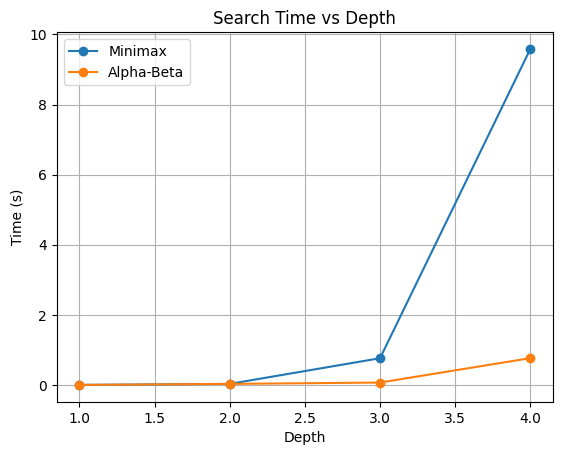

In [ ]:
# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

# Time vs Depth
plt.figure()
plt.plot(depths, times_mm, marker='o', label='Minimax')
plt.plot(depths, times_ab, marker='o', label='Alpha-Beta')
plt.xlabel('Depth'); plt.ylabel('Time (s)')
plt.title('Search Time vs Depth')
plt.legend(); plt.grid(True)
plt.show()

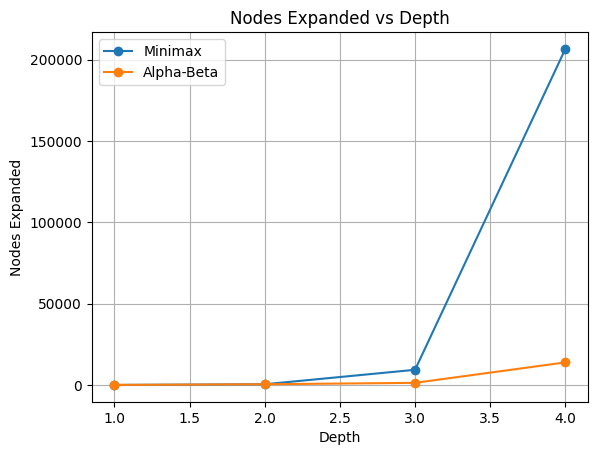

In [ ]:
# Nodes vs Depth
plt.figure()
plt.plot(depths, nodes_mm, marker='o', label='Minimax')
plt.plot(depths, nodes_ab, marker='o', label='Alpha-Beta')
plt.xlabel('Depth'); plt.ylabel('Nodes Expanded')
plt.title('Nodes Expanded vs Depth')
plt.legend(); plt.grid(True)
plt.show()

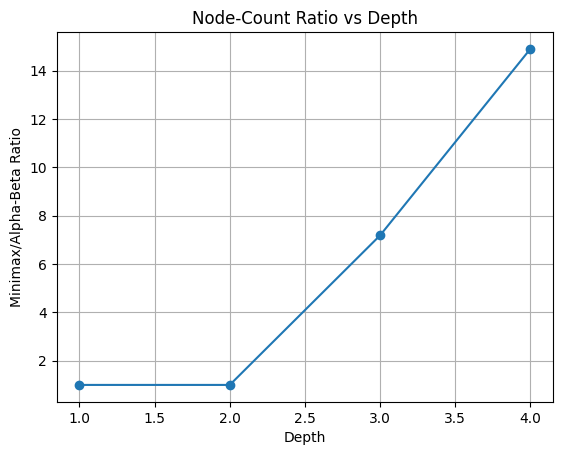

In [ ]:
# Node-Count Ratio
ratios = [m/a if a>0 else None for m, a in zip(nodes_mm, nodes_ab)]
plt.figure()
plt.plot(depths, ratios, marker='o')
plt.xlabel('Depth'); plt.ylabel('Minimax/Alpha-Beta Ratio')
plt.title('Node-Count Ratio vs Depth')
plt.grid(True)
plt.show()

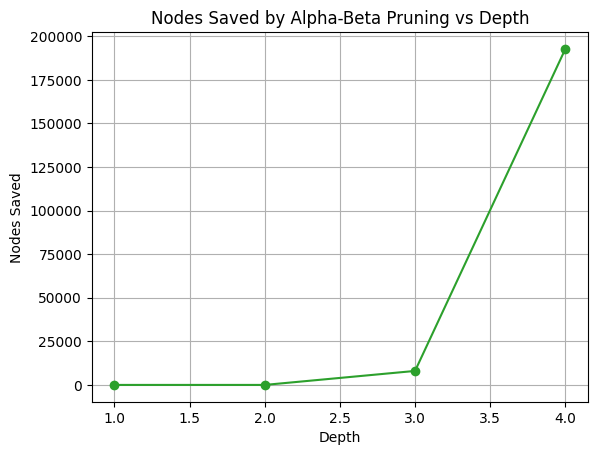

In [ ]:
#Nodes Saved by Pruning
# Plotting how many fewer nodes Alpha-Beta expands than Minimax at each depth:
# Saved(d)=nodes_mm(d)−nodes_ab(d)
import numpy as np
saved = np.array(nodes_mm) - np.array(nodes_ab)
plt.figure()
plt.plot(depths, saved, marker='o', color='tab:green')
plt.xlabel('Depth')
plt.ylabel('Nodes Saved')
plt.title('Nodes Saved by Alpha-Beta Pruning vs Depth')
plt.grid(True)
plt.show()

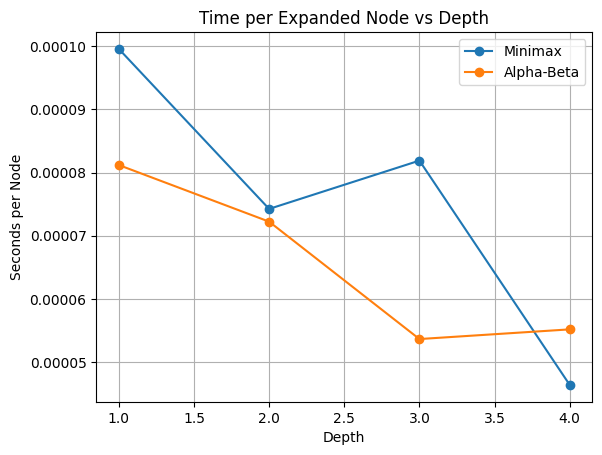

In [ ]:
#Time per Node vs Depth
# Guard against division by zero
tpm_mm = [t/n if n>0 else 0 for t,n in zip(times_mm, nodes_mm)]
tpm_ab = [t/n if n>0 else 0 for t,n in zip(times_ab, nodes_ab)]
plt.figure()
plt.plot(depths, tpm_mm, marker='o', label='Minimax')
plt.plot(depths, tpm_ab, marker='o', label='Alpha-Beta')
plt.xlabel('Depth')
plt.ylabel('Seconds per Node')
plt.title('Time per Expanded Node vs Depth')
plt.legend()
plt.grid(True)
plt.show()


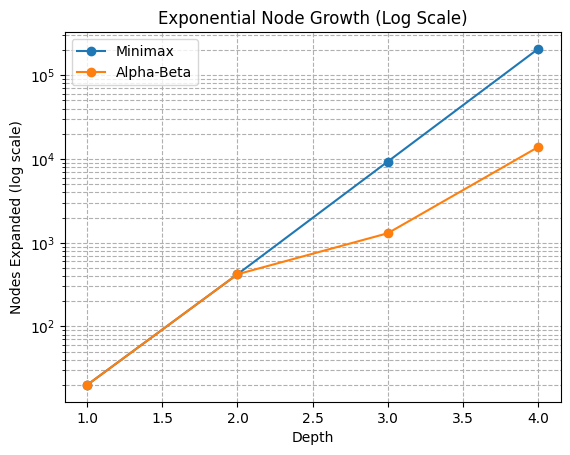

In [ ]:
#Log-Scale Node Counts
plt.figure()
plt.plot(depths, nodes_mm, marker='o', label='Minimax')
plt.plot(depths, nodes_ab, marker='o', label='Alpha-Beta')
plt.yscale('log')
plt.xlabel('Depth')
plt.ylabel('Nodes Expanded (log scale)')
plt.title('Exponential Node Growth (Log Scale)')
plt.legend()
plt.grid(True, which='both', ls='--')
plt.show()

**About above plots**
- **Nodes Saved vs Depth** -Exactly how many nodes pruning saves
- **Time per Node vs Depth** -Relative overhead of evaluation per node
- **Log-Scale Node Counts**- True exponential behavior of pure Minimax versus pruned search


**Why These Results?**
- **Time plot:** Alpha-Beta runs much faster as depth grows because pruning cuts entire subtrees, whereas Minimax visits every node.
- **Node plot:** At depth 4, Minimax might explore ∼O(b⁴) nodes, while Alpha-Beta often explores far fewer (best‐case ≈O(b²)).
- **Ratio plot:** The increasing Minimax/Alpha-Beta ratio directly visualizes pruning efficiency.
